In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
from tqdm import tqdm
import time
import pickle
import metric_learn
from sklearn.decomposition import PCA  
from sklearn import cluster, datasets, mixture

In [2]:
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

def calc_leq(df, unit):
    df.reset_index(inplace=True, drop=True)
    for i in range(int(len(df)/unit)+1):
        hour_df=df.loc[i*unit:(i+1)*unit, 'original'].copy()
        N=len(hour_df)
        Leq=10*np.log10(np.sum(np.power(10, hour_df/10)))-10*np.log10(N)
        df.loc[i*unit:(i+1)*unit, 'leq']=Leq
    return df

def leq_filter(df):
    df=calc_leq(df, 18000)
    df.loc[(df['original']<df['leq']), 'd']=0
    return df

def validate(test_v, anorm, thr=0.2):
    test_v['z']=np.where(anorm>=thr, 1, 0)
    test_v.reset_index(inplace=True, drop=True)

    #     適合率
    tp=test_v[(test_v['label']==1)&(test_v['z']==1)]
    z_p=test_v[test_v['z']==1]
    pre_score=len(tp)/len(z_p)

    #     再現率
    df_anorm=[]
    search= 1 if test_v.loc[0, 'label']==0 else 0
    for num in range(len(test_v)):
        if search==1 and test_v.loc[num, 'label']==search:
            start=num
            search=0
        elif search==0 and test_v.loc[num, 'label']==search:
            stop=num-1
            anorm_range=test_v.loc[start:stop].copy()
            df_anorm.append(anorm_range)
            search=1
            
    count=[]
    for i in range(len(df_anorm)):
        if len(df_anorm[i].loc[df_anorm[i]['z']==1])>=1:
               count.append(i)    

    re_score=len(count)/len(df_anorm)

    return pre_score, re_score

def figure(df_test, d, thr):
    plt.rcParams["font.size"] = 20
    plt.rcParams["font.family"] = "Times New Roman"
    df_test=df_test.copy()
    df_test['z']=np.where(d>=thr, 1, 0)
    
    z=df_test['z'].values*100
    test_plot=df_test['original'].values
    num_ax=math.ceil(len(test_plot)/17999)
    label=df_test['label'].values*100
    label_index=range(len(label))
    time_unit=60
    time=[t*0.2/60 for t in range(len(d))]
    time_unit_data=18000
    fig, ax=plt.subplots(num_ax, 1, figsize=(35, 16*num_ax))
    plt.subplots_adjust(hspace=0.35)
    for i in range(num_ax):
        ax[i].plot(time[i*time_unit_data:time_unit_data*(i+1)], d[i*time_unit_data:time_unit_data*(i+1)], '-r',linewidth = 1, label='異常度')
        ax[i].fill_between(time[i*time_unit_data:time_unit_data*(i+1)], label[i*time_unit_data:time_unit_data*(i+1)], facecolor='lime', label='異常ラベル' )

#         #異常と判別したところを強調したい場合
#         ax[i].fill_between(time[i*time_unit_data:time_unit_data*(i+1)], z[i*time_unit_data:time_unit_data*(i+1)], facecolor='steelblue' )
        
        ax2=ax[i].twinx()
        ax2.plot(time[i*time_unit_data:time_unit_data*(i+1)], test_plot[i*time_unit_data:time_unit_data*(i+1)], '-k',linewidth = 2, label='騒音レベル')

        ax[i].set_xticks(np.arange(60*i, 60*(i+1),3))
        ax[i].set_xticklabels(np.arange(60*i, 60*(i+1),3), fontsize=40)
        ax[i].xaxis.set_tick_params(rotation=30)
        ax[i].set_xlim(i*time_unit, time_unit*(i+1))
        
        ax[i].set_yticks(np.arange(0, 12, 2)/10)
        ax[i].set_yticklabels(np.arange(0, 12, 2)/10, fontsize=40)
        
        ax2.set_yticks(np.arange(40, 90, 10))
        ax2.set_yticklabels(np.arange(40, 90, 10), fontsize=40)
        
        ax[i].set_ylim(0, 2)
        ax2.set_ylim(10, 80)
        h1, l1 = ax[i].get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax[i].legend(h2+h1, l2+l1, loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3, prop={'family':"MS Mincho", 'size':40})
        ax[i].set_xlabel('時点(分)', fontfamily="MS Mincho",fontsize=40)
        ax[i].set_ylabel('　　　異常度', fontfamily="MS Mincho",fontsize=40, loc='bottom')
        ax2.set_ylabel('　騒音レベル値(dB)', fontfamily="MS Mincho",fontsize=40, loc='top')
    plt.show()
    return df_test

def figure_detail(df_test, d_test, start=0, stop=60):
    plt.rcParams["font.size"] = 20
    plt.rcParams["font.family"] = "Times New Roman"
    
    start_data=int(math.floor(start)*60/0.2)
    stop_data=int(math.ceil(stop)*60/0.2)

    test_plot=df_test['original'].values[start_data:stop_data]
    d=d_test[start_data:stop_data]
    label=df_test['label'].values[start_data:stop_data]*100
    label_index=range(len(label))

    time=[t*0.2/60 for t in range(start_data, stop_data)]
    fig, ax=plt.subplots(1, 1, figsize=(35, 16))

    ax.plot(time, test_plot, '-k',linewidth = 2, label='騒音レベル')
    ax2=ax.twinx()
    ax2.plot(time, d, '-r',linewidth = 2, label='異常度')
    ax.fill_between(time, label, facecolor='lime', label='異常ラベル' )

    ax.set_xticks(np.arange(math.floor(start), math.ceil(stop), 1))
    ax.set_xticklabels(np.arange(math.floor(start), math.ceil(stop), 1), fontsize=50)
#     ax.xaxis.set_tick_params(rotation=30)
    ax.set_xlim(start, stop)

    ax.set_yticks(np.arange(40, 90, 10))
    ax.set_yticklabels(np.arange(40, 90, 10), fontsize=50)        
    ax.set_ylim(40, 80)
    
    ax2.set_yticks(np.arange(0, 12, 2)/10)
    ax2.set_yticklabels(np.arange(0, 12, 2)/10, fontsize=50)

    ax2.set_ylim(0, 2)
    ax.set_ylim(10, 80)

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h2+h1, l2+l1, loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3, prop={'family':"MS Mincho", 'size':53})
    ax.set_xlabel('時点(分)', fontfamily="MS Mincho",fontsize=53)
    ax.set_ylabel('騒音レベル値(dB)　', fontfamily="MS Mincho",fontsize=53, loc='top')
    ax2.set_ylabel('　　　異常度', fontfamily="MS Mincho",fontsize=53, loc='bottom')
    plt.show()    
    
def fig_pr(test_v, d, bins):
    plt.rcParams["font.size"] = 15
    plt.rcParams["font.family"] = "Times New Roman"
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)
    f_score=(2*precision*recall)/(precision+recall)
    thr=thresholds[np.argmax(f_score)]

#     #F値が最大になる点を明示したい場合
#     plt.plot(recall, precision, marker='o', markevery=[np.argmax(f_score)], label='PR curve (AUC = %.2f)'%auc)
    #明示しなくていい場合
    plt.plot(recall, precision, '-k',linewidth = 2, label='PR曲線')
    
#     plt.legend(prop={'family':"MS Mincho"}, loc="lower left")
    plt.xlabel('再現率', fontfamily="MS Mincho")
    plt.ylabel('適合率', fontfamily="MS Mincho")
    plt.grid(True)
    plt.show()

    return precision, recall, f_score, thresholds, thr, auc

def auc_gs(test_v, d, bins):
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)

    return auc

def fig_th_f(thresholds, f_score):
    plt.rcParams["font.size"] = 20
    plt.rcParams["font.family"] = "Times New Roman"
    plt.plot(thresholds, f_score, marker="o", markevery=[np.argmax(f_score)])
    plt.xlabel('thresholds')
    plt.ylabel('f_score')
    plt.grid(True)
    plt.show()
    
    return thresholds[np.argmax(f_score)], f_score.max()

In [3]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

original  label  time  day
0            53.4      0    15    0
1            52.8      0    15    0
2            52.8      0    15    0
3            53.2      0    15    0
4            53.6      0    15    0
...           ...    ...   ...  ...
3995345      45.9      0     5    9
3995346      45.6      0     5    9
3995347      45.8      0     5    9
3995348      45.7      0     5    9
3995349      45.9      0     5    9

[3995350 rows x 4 columns]

# ホールドアウト検証
## 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
---
ラベル付け
* 全体：0, 1, 2, 3, 4, 5 日目
* 訓練ローテ：(訓練、ラベル付与対象)=([0, 1, 2, 3, 4], 5)・・・([5, 0, 1, 2, 3], 4)

In [4]:
best_params={'window': 5, 'nk': 12}

In [5]:
test_day=[6, 7, 8, 9]
semi_train_day=[0, 1, 2, 3, 4, 5]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)

In [6]:
df_list=[]

window=best_params['window']
for i in set(df['day']):
    lag=[] 
    lag.append(make_data(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train_df=pd.concat(df_list)
semi_train_df=semi_train_df.dropna().reset_index(drop=True)
semi_train_df.loc[:, 'pred']=0

In [7]:
semi_train_df

original  original_lag1  original_lag2  original_lag3  original_lag4  \
0            53.6           53.2           52.8           52.8           53.4   
1            54.0           53.6           53.2           52.8           52.8   
2            54.7           54.0           53.6           53.2           52.8   
3            55.7           54.7           54.0           53.6           53.2   
4            55.5           55.7           54.7           54.0           53.6   
...           ...            ...            ...            ...            ...   
2393381      45.0           45.4           45.1           44.8           45.4   
2393382      45.2           45.0           45.4           45.1           44.8   
2393383      45.1           45.2           45.0           45.4           45.1   
2393384      45.1           45.1           45.2           45.0           45.4   
2393385      46.0           45.1           45.1           45.2           45.0   

         day  label  pred  
0          0      0     0  
1          0      0     0  
2          0      0     0  
3          0      0     0  
4          0      0     0  
...      ...    ...   ...  
2393381    5      0     0  
2393382    5      0     0  
2393383    5      0     0  
2393384    5      0     0  
2393385    5      0     0  

[2393386 rows x 8 columns]

## DBSCAN

In [8]:
semi_train_df['scaned']=0
# 自己一致を避けるために10ステップ間隔で系統抽出
step=10
for i in range(step):
    dataset=semi_train_df[semi_train_df.columns[:-4]][i::step]
    index=list(dataset.index)
    dbscan_dataset= cluster.DBSCAN(eps=0.3, min_samples=10, metric='euclidean').fit_predict(dataset.values)
    semi_train_df.loc[index, 'scaned']=dbscan_dataset

original  original_lag1  original_lag2  original_lag3  original_lag4  \
0            53.6           53.2           52.8           52.8           53.4   
1            54.0           53.6           53.2           52.8           52.8   
2            54.7           54.0           53.6           53.2           52.8   
3            55.7           54.7           54.0           53.6           53.2   
4            55.5           55.7           54.7           54.0           53.6   
...           ...            ...            ...            ...            ...   
2393381      45.0           45.4           45.1           44.8           45.4   
2393382      45.2           45.0           45.4           45.1           44.8   
2393383      45.1           45.2           45.0           45.4           45.1   
2393384      45.1           45.1           45.2           45.0           45.4   
2393385      46.0           45.1           45.1           45.2           45.0   

         day  label  pred  scaned  
0          0      0     0       0  
1          0      0     0       0  
2          0      0     0       0  
3          0      0     0       0  
4          0      0     0       0  
...      ...    ...   ...     ...  
2393381    5      0     0       0  
2393382    5      0     0       0  
2393383    5      0     0       0  
2393384    5      0     0       0  
2393385    5      0     0       0  

[2393386 rows x 9 columns]

In [31]:
labeling_day_num=1
cv_comb=np.array(semi_train_day).reshape((-1, labeling_day_num)).tolist()
cv_comb

[[0], [1], [2], [3], [4], [5]]

## （教師なし）K近傍法でラベル付与

In [33]:
for i in cv_comb:
    label_train_day=[k for k in semi_train_day if k not in i]
    label_grant_day=i
    print(f'訓練データ：{label_train_day}')
    print(f'ラベル付与データ：{label_grant_day}日目')

    semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))&(semi_train_df['scaned']==0)][semi_train_df.columns[:-4]].reset_index(drop=True)
    labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-4]].reset_index(drop=True)

    nk = best_params['nk']
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(semi_train_x)
    d = neigh.kneighbors(labeling_x)[0]
    d = np.mean(d, axis=1)
    
    semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'pred']=d
    
    #閾値設定
    #kmeans
    n_clusters=2
    #init default=’k-means++’
    model = KMeans(n_clusters=n_clusters, n_init=10)  
    model.fit(d.reshape((-1, 1)))
    clusters = model.predict(d.reshape((-1, 1)))  
    result=pd.DataFrame({'d':d, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = float(thr_range.quantile(0.25).iloc[0])
    Q3 = float(thr_range.quantile(0.75).iloc[0])
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    
    semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'pred']\
    = np.where(semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'pred']>=thr, 1, 0)
    print('------------------------------------------------------')
semi_train_df_tmp=semi_train_df[['original', 'day', 'pred', 'label', 'scaned']]
semi_train_df_tmp.to_csv('semi_train_data/semi_train_df.csv')

訓練データ：[1, 2, 3, 4, 5]
ラベル付与データ：[0]日目
------------------------------------------------------
訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目
------------------------------------------------------
訓練データ：[0, 1, 3, 4, 5]
ラベル付与データ：[2]日目
------------------------------------------------------
訓練データ：[0, 1, 2, 4, 5]
ラベル付与データ：[3]日目
------------------------------------------------------
訓練データ：[0, 1, 2, 3, 5]
ラベル付与データ：[4]日目
------------------------------------------------------
訓練データ：[0, 1, 2, 3, 4]
ラベル付与データ：[5]日目
------------------------------------------------------


## 半教師あり学習済みデータの読み込み

In [83]:
semi_train_df= pd.read_csv('semi_train_data/semi_train_df.csv', index_col=0)
semi_train_df

original  day  pred  label  scaned  lofed
0            53.6    0   0.0      0       0    0.0
1            54.0    0   0.0      0       0    0.0
2            54.7    0   0.0      0       0    0.0
3            55.7    0   0.0      0      -1    0.0
4            55.5    0   0.0      0      -1    0.0
...           ...  ...   ...    ...     ...    ...
2393381      45.0    5   0.0      0       0    0.0
2393382      45.2    5   0.0      0       0    0.0
2393383      45.1    5   0.0      0       0    0.0
2393384      45.1    5   0.0      0       0    0.0
2393385      46.0    5   0.0      0       0    0.0

[2393386 rows x 6 columns]

In [84]:
print(f'訓練データ（学習用）：{semi_train_day}日目')
print(f'テストデータ（最終評価用）：{test_day}日目')
metric_learn_w=5

df_list=[]
df_list=[]
for i in semi_train_day:
    lag=[] 
    lag.append(make_data(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', metric_learn_w))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day', 'pred', 'scaned', 'lofed', 'label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train=pd.concat(df_list)
semi_train=semi_train.dropna().reset_index(drop=True)
semi_train

訓練データ（学習用）：[0, 1, 2, 3, 4, 5]日目
テストデータ（最終評価用）：[6, 7, 8, 9]日目


original  original_lag1  original_lag2  original_lag3  original_lag4  \
0            55.5           55.7           54.7           54.0           53.6   
1            55.7           55.5           55.7           54.7           54.0   
2            55.6           55.7           55.5           55.7           54.7   
3            55.8           55.6           55.7           55.5           55.7   
4            55.7           55.8           55.6           55.7           55.5   
...           ...            ...            ...            ...            ...   
2393357      45.0           45.4           45.1           44.8           45.4   
2393358      45.2           45.0           45.4           45.1           44.8   
2393359      45.1           45.2           45.0           45.4           45.1   
2393360      45.1           45.1           45.2           45.0           45.4   
2393361      46.0           45.1           45.1           45.2           45.0   

         day  pred  scaned  lofed  label  
0          0   0.0      -1    0.0      0  
1          0   0.0       0    0.0      0  
2          0   0.0       0    0.0      0  
3          0   0.0       0    0.0      0  
4          0   0.0       0    0.0      0  
...      ...   ...     ...    ...    ...  
2393357    5   0.0       0    0.0      0  
2393358    5   0.0       0    0.0      0  
2393359    5   0.0       0    0.0      0  
2393360    5   0.0       0    0.0      0  
2393361    5   0.0       0    0.0      0  

[2393362 rows x 10 columns]

In [85]:
semi_train_0=semi_train[(semi_train['pred']!=1)&(semi_train['lofed']!=1)]
train_x=semi_train_0[semi_train_0.columns[:-5]].values

In [86]:
df_list=[]
for i in test_day:
    lag=[] 
    lag.append(make_data(test_df.loc[test_df['day']==i, ['original']], 'original', metric_learn_w))
    lag.append(test_df.loc[test_df['day']==i, ['day', 'label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
test=pd.concat(df_list)
test=test.dropna().reset_index(drop=True)

test_x=test[test.columns[:-2]].values
test_y=test[test.columns[-1]].values

# K近傍法

In [89]:
#処理時間の計測
time_start=time.perf_counter()

nk=best_params['nk']
neigh = NearestNeighbors(n_neighbors=nk)
neigh.fit(train_x)
d = neigh.kneighbors(test_x)[0]
d = np.mean(d, axis=1)

time_end = time.perf_counter()
processing_time=time_end-time_start
print(f'異常度算出にかかる処理時間：{processing_time}秒')

test_v=test[['original', 'label']].copy().reset_index(drop=True)
test_v['d']=d

#道路交通騒音に埋もれている異常音は正常とする
test_v=leq_filter(test_v)
test_v['d']=test_v['d']/test_v['d'].max()
d_test=test_v['d'].values

test_v['time']=[t * 0.2 / 60 for t in range(len(d_test))]

異常度算出にかかる処理時間：119.52074950002134秒


# PR曲線

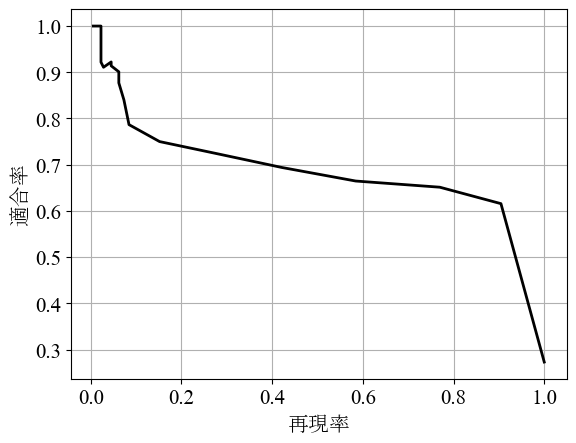

AUC：0.6785173006785435
理想の閾値：0.04
F値（最高）：0.7326416518234526
適合率（最高）：0.6156659413916022
再現率（最高）：0.9044943820224719


In [90]:
thr_bins=20
p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
print('\033[31m'+f'AUC：{auc}'+'\033[0m')
print(f'理想の閾値：{thr}')
print(f'F値（最高）：{f_score.max()}')
print(f'適合率（最高）：{p_score[np.argmax(f_score)]}')
print(f'再現率（最高）：{r_score[np.argmax(f_score)]}')

# 異常度可視化

In [91]:
p, r=validate(test_v, d_test, thr)
print(f'適合率：{p}')
print(f'再現率：{r}')

適合率：0.6156659413916022
再現率：0.9044943820224719


In [92]:
test_day

[6, 7, 8, 9]

In [93]:
check_day=6
check_test_v=test_v.iloc[test.loc[test['day']==check_day].index, :]
check_d_test=check_test_v['d'].values

In [94]:
check_test_v=figure(check_test_v, check_d_test, thr)